<h1>Data Cleaning</h1>

# 1 Imports

In [1]:
import sys
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fuzzywuzzy import process
from unidecode import unidecode

sys.path.insert(0, r"C:\Users\vynde\PycharmProjects\dataanalysis")
from databridger import Database
import databridger as da

# Issue Tracking

In [2]:
# TODO: export class to module and import it

class CustomDataFrame(pd.DataFrame):
    """Subclass of pandas DataFrame with custom formatting capabilities.
    
    Features:
    - Provides a custom 'formatted' property that returns a styled version of 
      the DataFrame with custom formatting.
    - Ensures that operations on the CustomDataFrame will return a new instance
      of CustomDataFrame, rather than a basic pandas DataFrame.
    """

    FORMAT_LINE_BREAK = {
        'description': lambda x: str(x).replace("\n", "<br>"), 
        'notes': lambda x: str(x).replace("\n", "<br>"), 
        'relevant_data': lambda x: str(x).replace("\n", "<br>")}

    @property
    def formatted(self):
        """Returns a styled version of the DataFrame where specific columns 
        have their newlines replaced with HTML line breaks."""
        return self.style.format(self.FORMAT_LINE_BREAK)

    @property
    def _constructor(self):
        """Ensures that any operations that return a new DataFrame instance
        (like slicing, querying, etc.) will return an instance of CustomDataFrame
        instead of a basic pandas DataFrame. This is important to ensure that 
        the methods and properties we've defined in our subclass are available
        in the resulting DataFrame objects."""
        return CustomDataFrame

    def __finalize__(self, other, method=None, **kwargs):
        """This method is a part of pandas' inheritance mechanism and is called 
        whenever a new object is created as a result of some operation.
        By overriding this method and calling the parent class's `__finalize__`,
        we can ensure that any custom attributes or methods are properly carried
        over to the new object."""
        return super().__finalize__(other, method=method, **kwargs)


class IssueTracker:
    VALID_FIELDS = ["description", "resolution", "potential_cause", "relevant_data", "notes"]

    def __init__(self):
        self.df = pd.DataFrame(columns=["issue_id", "version", "status", *self.VALID_FIELDS])
        self.issue_count = 0
    
    def __repr__(self):
        return self.df.__repr__()

    def _repr_html_(self):
        return self.df._repr_html_()

    def show(self):
        return CustomDataFrame(self.df)
    
    def show_latest_versions(self):
        return CustomDataFrame(self.df.groupby("issue_id").last())
            
    def add_issue(self, description, potential_cause=None, relevant_data=None, notes=None):
        issue = {
            "issue_id": self.issue_count + 1,
            "version": 1, 
            "status": "Open",
            "description": description,
            "resolution": None,
            "potential_cause": potential_cause,
            "relevant_data": relevant_data,
            "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            "notes": notes
        }
        self.df = pd.concat([self.df, pd.DataFrame([issue])], ignore_index=True)
        
        self.issue_count += 1

        issue_str = f'Issue.{issue["issue_id"]}.{issue["version"]}'
        descr_str = issue["description"]
        reldata_str = issue["relevant_data"].replace("\n", " and ")
        print("---\n")
        print(f'{issue_str} ({descr_str})')
        print(f'Data: {reldata_str}')
        if issue["potential_cause"]:
            print("\n---\n")
            print(f'Potential cause: {issue["potential_cause"]}')
        if notes:
            print("\n---\n")
            print(f'{notes}')
        print("\n---\n")

    def update_issue(self, /, status=None, description=None, potential_cause=None, relevant_data=None, notes=None, issue_id=None, resolution=None):

        if issue_id is None:
            issue = self.df.iloc[-1]
        else:
            issue = self.df.loc[self.df["issue_id"]==issue_id, :].iloc[-1]

        new_issue = issue.copy()

        new_issue["version"] = issue["version"] + 1

        if (new_issue["status"] == "resolved") and (issue["issue_id"] == new_issue["issue_id"]):
            raise Exception("Issue already resolved.")
        
        # Apply the updates
        if status is not None:
            new_issue["status"] = status
        if description is not None:
            new_issue["description"] = description
        if potential_cause is not None:
            new_issue["potential_cause"] = potential_cause
        if relevant_data is not None:
            new_issue["relevant_data"] = relevant_data
        if resolution is not None:
            new_issue["resolution"] = resolution
        
        # overwrite notes always
        new_issue["notes"] = notes
        
        self.df = pd.concat([self.df, pd.DataFrame([new_issue])])

        issue_str = f'Issue.{new_issue["issue_id"]}.{new_issue["version"]}'
        descr_str = new_issue["description"]
        reldata_str = new_issue["relevant_data"].replace("\n", " and ")
        print("---\n")
        print(f'{issue_str} ({descr_str})')
        print(f'Data: {reldata_str}')
        if new_issue["potential_cause"]:
            print("\n---\n")
            print(f'Potential cause: {new_issue["potential_cause"]}')
        if notes:
            print("\n---\n")
            print(f'{notes}')
        print("\n---\n")

    def resolve_issue(self, resolution, issue_id=None):
        if not issue_id:
            issue_id = self.issue_count

        self.update_issue(status="resolved", resolution=resolution, issue_id=issue_id)

        print(f"Resolved: {resolution}")

    def export_to_csv(self, filename="issues.csv"):
        self.df.to_csv(filename, index=False)

# create instance
issue_tracker = IssueTracker()

# 2 Resources

In [3]:
# folders
raw_data_folder = Path('..') / 'data' / 'raw'
report_folder = Path('..') / 'reports'

# output files
database_summary_file = report_folder / "database_summary.xlsx"
overlap_ratio_file = report_folder / "column_overlap_ratios.xlsx"

---

# 3 Load Data

New method for loading file based data base

In [4]:
db_csv = Database(raw_data_folder)
db_csv.columns_mapping

,from_table,from_column,to_table,to_column
0,olist_customers_dataset,customer_id,olist_orders_dataset,customer_id
1,olist_orders_dataset,order_id,olist_order_items_dataset,order_id
2,olist_orders_dataset,order_id,olist_order_payments_dataset,order_id
3,olist_orders_dataset,order_id,olist_order_reviews_dataset,order_id
4,olist_orders_dataset,customer_id,olist_customers_dataset,customer_id
5,olist_order_items_dataset,order_id,olist_orders_dataset,order_id
6,olist_order_items_dataset,order_id,olist_order_payments_dataset,order_id
7,olist_order_items_dataset,order_id,olist_order_reviews_dataset,order_id
8,olist_order_items_dataset,product_id,olist_products_dataset,product_id
9,olist_order_items_dataset,seller_id,olist_sellers_dataset,seller_id


Inspect file names

In [5]:
for csv_file in raw_data_folder.glob('*.csv'):
    print(csv_file)

..\data\raw\olist_customers_dataset.csv
..\data\raw\olist_geolocation_dataset.csv
..\data\raw\olist_orders_dataset.csv
..\data\raw\olist_order_items_dataset.csv
..\data\raw\olist_order_payments_dataset.csv
..\data\raw\olist_order_reviews_dataset.csv
..\data\raw\olist_products_dataset.csv
..\data\raw\olist_sellers_dataset.csv
..\data\raw\product_category_name_translation.csv


Load all data sets into a database (dictionary of dataframes)

In [6]:
db = dict()  # database
for csv_file in raw_data_folder.glob('*.csv'):
    dataset_name = str(csv_file.stem).replace("olist_", "").replace("_dataset", "")
    db[dataset_name] = pd.read_csv(csv_file)

db.keys()

dict_keys(['customers', 'geolocation', 'orders', 'order_items', 'order_payments', 'order_reviews', 'products', 'sellers', 'product_category_name_translation'])

Convert to datetime matching this format yyyy-mm-dd HH:MM:SS

In [7]:
for key in db:
    for column in db[key].columns:
        if db[key][column].dtype == 'object':
            if all(db[key][column].str.match(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}")):
                db[key][column] = pd.to_datetime(db[key][column])
                print(f"converted:   {key:15} / {column:30} from object to {db[key][column].dtype}")

# also tried another version with try except trying to convert every object-type column to datetime
# showed a very strange behavior and messed up all types in the dataframe


converted:   orders          / order_purchase_timestamp       from object to datetime64[ns]
converted:   orders          / order_approved_at              from object to datetime64[ns]
converted:   orders          / order_delivered_carrier_date   from object to datetime64[ns]
converted:   orders          / order_delivered_customer_date  from object to datetime64[ns]
converted:   orders          / order_estimated_delivery_date  from object to datetime64[ns]
converted:   order_items     / shipping_limit_date            from object to datetime64[ns]
converted:   order_reviews   / review_creation_date           from object to datetime64[ns]
converted:   order_reviews   / review_answer_timestamp        from object to datetime64[ns]


> **Summary**: 
>- Loaded 9 CSV files into a dictionary, effectively creating a database.
>- Identified 8 columns as datetime columns

---

# 4 Database Column Characterization & Classification

Database overview

In [8]:
for name, df in db.items():
    print(f"{name}: {df.shape}")
    print(df.dtypes)
    print()

customers: (99441, 5)
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

geolocation: (1000163, 5)
geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

orders: (99441, 8)
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

order_items: (112650, 7)
order_id                       object
order_item_id                   int64
product_id                     ob

## 4.1 Generic Analysis of Key Relationships Across Tables

Instead of relying on the naming convention with `_id` as a suffix for key variables, this method is a generic approach to identify primary and foreign keys and their relationship across the tables in the database.

Therefore, for each column in the database we check if it is a subset of another column, resulting in a matrix (dataframe) of `subset_ratio`s. A `subset_ratio` of 1 shows that all values of one column can be found in another column.

The index holds the variables which are potential subsets (i.e. potential foreign keys) and the column names are potential primary keys. Note that primary keys columns have to be unique and foreign key columns can have duplicated values.

In [9]:
# List of unique columns which are potential primary keys
potential_primary_keys = [
    (table, column) 
    for table in db.keys() 
    for column in db[table].columns 
    if db[table][column].is_unique]
potential_primary_keys

[('customers', 'customer_id'),
 ('orders', 'order_id'),
 ('orders', 'customer_id'),
 ('products', 'product_id'),
 ('sellers', 'seller_id'),
 ('product_category_name_translation', 'product_category_name'),
 ('product_category_name_translation', 'product_category_name_english')]

Manual correction: The entity relationship diagram of the dataset on Kaggle shows another primary key `zip_code_prefix` in the `geolocation` table which is not listed here because it's not unique.

In [10]:
# add missing primary key
db["geolocation"]["geolocation_zip_code_prefix"]  # verify that it exists
potential_primary_keys.append(("geolocation", "geolocation_zip_code_prefix"))

In [11]:
# All columns are potential foreign keys
potential_foreign_keys = [
    (table, column) 
    for table in db.keys() 
    for column in db[table].columns]

The subset_ratio threshold defines the minimum subset_ratio where a column is called to be a subset of another.

A threshold below 1 assures that foreign-to-primary-key relationships even if there are missing entries

In [12]:
ssr_threshold = 0.95

Identify foreign-key-to-primary-key relationships by calculating the `subset_ratio`s

In [13]:
def compute_subset_ratio(from_column, to_column):
    from_set = set(from_column.dropna())
    to_set = set(to_column.dropna())

    # Number of matching entries
    matching_entries = len(from_set.intersection(to_set))

    # Total unique entries in both columns
    total_entries = len(to_set)

    return matching_entries / total_entries if total_entries != 0 else 0

# Init column mapping dataframe
columns = ["from_table", "from_column", "to_table", "to_column", "subset_ratio"]
df_column_mapping = pd.DataFrame(columns=columns)

# Loop over potential primary keys and foreign keys
for tab_a, col_a in potential_primary_keys:
    for tab_b, col_b in potential_foreign_keys:
        # Don't compare one column to itself
        if (tab_a, col_a) != (tab_b, col_b):
            # Calculate subset ratio
            ssr = compute_subset_ratio(db[tab_a][col_a], db[tab_b][col_b])
            # If it is above the threshold, add the connection
            if ssr >= ssr_threshold:
                values = [tab_b, col_b, tab_a, col_a, ssr]
                new_df_row = pd.DataFrame([dict(zip(columns, values))])
                df_column_mapping = pd.concat([df_column_mapping, new_df_row], ignore_index=True)

In [14]:
df_column_mapping

,from_table,from_column,to_table,to_column,subset_ratio
0,orders,customer_id,customers,customer_id,1.000000
1,order_items,order_id,orders,order_id,1.000000
2,order_payments,order_id,orders,order_id,1.000000
3,order_reviews,order_id,orders,order_id,1.000000
4,customers,customer_id,orders,customer_id,1.000000
5,order_items,product_id,products,product_id,1.000000
6,order_items,seller_id,sellers,seller_id,1.000000
7,products,product_category_name,product_category_name_translation,product_category_name,0.972603
8,customers,customer_zip_code_prefix,geolocation,geolocation_zip_code_prefix,0.989529
9,sellers,seller_zip_code_prefix,geolocation,geolocation_zip_code_prefix,0.996883


In [15]:
foreign_keys = df_column_mapping[["from_table", "from_column"]].to_numpy().tolist()
primary_keys = df_column_mapping[["to_table", "to_column"]].to_numpy().tolist()

## 4.2 Classify and Summarize all Columns

This approach scans each column in the dataset to determine its type and, if applicable, subtype based on several conditions. It's a straightforward but somewhat rudimentary method of using chained `if/else` statements to discern the classifications. While effective for this analysis, such a method can become cumbersome and less maintainable as the complexity or number of conditions grows. However, for the current scope, it provides a clear and easily understandable logic.

**Types**:
- **Key**: Identified if columns act as unique identifiers or establish relations.
    - **Primary**: Already identified as a primary key.
    - **Foreign**: Already identified as a foreign key.
    - **Internal**: A unique identifier without any relationship to other tables.
    - **Unknown**: Other columns with `_id` in their name. These are (maybe unintentinally) not unique!
- **Numeric**
    - **Continuous**: Floating-point numbers.
    - **Discrete**: Integer values.
    - **Unknown**: Numeric columns not fitting into the above categories.
- **Categorical**
    - **Nominal**: Default category for object datatypes with limited (10) unique values.
    - **Ordinal**
    - **Binary**
- **Temporal**: Detected if columns are of datetime datatype.
- **Spatial**: Identified by specific keywords (e.g., 'latitude', 'longitude', 'address', etc.) in the column name.
    - **Coordinates**
    - **Region**
- **Text**: Columns of object datatype (typically strings) with more than 10 unique values.
- **Unknown**: Any column not matching the above classifications.


In [16]:
# Cunstruct a list af all table-column pairs in the database to iterate over
all_table_column_pairs = [
    (table, column) 
    for table in db.keys() 
    for column in db[table].columns
]

summary = []

for table, column in all_table_column_pairs:
    series = db[table][column]

    # Initialize dictionary, later used as a dataframe row
    data = {"table": table, "column": column}
    
    # Common summary statistics for all types
    data["count"] = len(series)
    unique_count = series.nunique()
    data["unique_count"] = unique_count
    data["duplicated_count"] = len(series) - series.drop_duplicates().size
    data["missing_values"] = series.isna().sum()

    # Determine if the column is a key
    if ([table, column] in primary_keys) and ([table, column] in foreign_keys):
        # Key is unique in more than 1 table. Its membership is determined by name
        data["type"] = "key"
        # Get the table with the highest similarity score for the current column
        best_match_table, best_match_score = process.extractOne(column, db.keys())
        # If the current table has the highest similarity score, it's primary; otherwise, it's foreign
        if table == best_match_table:
            data["subtype"] = "primary"
        else:
            data["subtype"] = "foreign"
    elif ([table, column] in primary_keys):
        data["type"] = "key"
        data["subtype"] = "primary"
    elif ([table, column] in foreign_keys):
        data["type"] = "key"
        data["subtype"] = "foreign"
    elif (series.is_unique):
        data["type"] = "key"
        data["subtype"] = "internal"
    elif "_id" in column:
        data["type"] = "key"
        data["subtype"] = "unknown"
    # Determine if the column is temporal
    elif pd.api.types.is_datetime64_any_dtype(series):
        data["type"] = "temporal"
        if series.dt.time.nunique() == 1:  # Only the date varies
            data["subtype"] = "date"
        elif series.dt.date.nunique() == 1:  # Only the time varies
            data["subtype"] = "time"
        else:
            data["subtype"] = "datetime"
        # summary statistics
        data["min_date"] = series.min()
        data["max_date"] = series.max()
        data["range"] = series.max() - series.min()
    # Determine if column is some sort of spatial data
    elif any([kw in series.name.lower() for kw in ['latitude', 'longitude', 'lat', 'long', 'lng', 'geo', 'coordinates']]):
        data["type"] = "spatial"
        data["subtype"] = "coordinates"
    elif any([kw in series.name.lower() for kw in ['address', 'city', 'state', 'zipcode', 'zip_code', 'postcode', 'country', 'region', 'district', 'location']]):
        data["type"] = "spatial"
        data["subtype"] = "region"
    # Determine if the column is numeric
    elif pd.api.types.is_numeric_dtype(series):
        data["type"] = "numeric"
        if pd.api.types.is_integer_dtype(series) or (pd.api.types.is_float_dtype(series) and series.dropna().apply(float.is_integer).all()):
            data["subtype"] = "discrete"
        elif pd.api.types.is_float_dtype(series):
            data["subtype"] = "continuous"
        else:
            data["subtype"] = "unknown"
        # summary statistics
        data["min"] = series.min()
        data["max"] = series.max()
        data["mean"] = series.mean()
    # Determine if the column is text_
    # - is a object type (string)
    # - more than 10 unique counts
    elif (pd.api.types.is_object_dtype(series) and unique_count > 10):
        data["type"] = "text"
        data["subtype"] = "free-text"
        # summary statistics
        mode_data = series.mode()
        data["mode"] = mode_data[0] if not mode_data.empty else None
        data["mode_count"] = (series == data["mode"]).sum()
    # Determine if the column is categorical:
    # - other object types
    elif pd.api.types.is_object_dtype(series):
        data["type"] = "categorical"
        data["subtype"] = "nominal"
        # summary statistics
        mode_data = series.mode()
        data["mode"] = mode_data[0] if not mode_data.empty else None
        data["mode_count"] = (series == data["mode"]).sum()
    else:
        data["type"] = "unknown"
        data["subtype"] = "unknown"
    
    # Append the computed metrics for the column to the summary list
    summary.append(data)

# Compile the summary list into a DataFrame
df_summary = pd.DataFrame(summary)

# Split the dataframes by type and drop nan columns
df_summaries = {name: df.dropna(axis=1) for name, df in df_summary.groupby("type")}

In [17]:
df_summary.sort_values(by=["type", "subtype"])

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,mode,mode_count,min_date,max_date,range,min,max,mean
12,orders,order_status,99441,8,99433,0,categorical,nominal,delivered,96478.0,NaT,NaT,NaT,NaN,NaN,NaN
27,order_payments,payment_type,103886,5,103881,0,categorical,nominal,credit_card,76795.0,NaT,NaT,NaT,NaN,NaN,NaN
2,customers,customer_zip_code_prefix,99441,14994,84447,0,key,foreign,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN
11,orders,customer_id,99441,99441,0,0,key,foreign,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN
18,order_items,order_id,112650,98666,13984,0,key,foreign,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN
20,order_items,product_id,112650,32951,79699,0,key,foreign,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN
21,order_items,seller_id,112650,3095,109555,0,key,foreign,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN
25,order_payments,order_id,103886,99440,4446,0,key,foreign,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN
31,order_reviews,order_id,99224,98673,551,0,key,foreign,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN
38,products,product_category_name,32951,73,32877,610,key,foreign,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN


---

# 5 Inspect Data

## 5.1 Inspect Key Columns

In [18]:
df_summaries["key"].sort_values(by=["column"])

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype
0,customers,customer_id,99441,99441,0,0,key,primary
11,orders,customer_id,99441,99441,0,0,key,foreign
1,customers,customer_unique_id,99441,96096,3345,0,key,unknown
2,customers,customer_zip_code_prefix,99441,14994,84447,0,key,foreign
5,geolocation,geolocation_zip_code_prefix,1000163,19015,981148,0,key,primary
10,orders,order_id,99441,99441,0,0,key,primary
18,order_items,order_id,112650,98666,13984,0,key,foreign
25,order_payments,order_id,103886,99440,4446,0,key,foreign
31,order_reviews,order_id,99224,98673,551,0,key,foreign
19,order_items,order_item_id,112650,21,112629,0,key,unknown


### 5.1.1 `customer_id`

In [19]:
df_summaries["key"].query('column == "customer_id"')

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype
0,customers,customer_id,99441,99441,0,0,key,primary
11,orders,customer_id,99441,99441,0,0,key,foreign


Inspect why `customer_id` is unique in `customers` and `orders` table

In [20]:
issue_tracker.add_issue(
    description = "unique key in multiple tables",
    relevant_data = (
        "customers>customer_id\n"
        "orders>customer_id"),
    notes = (
        "one-to-one relationship;\n"
        "each customer has done exactly one order?;\n" 
        "structure intenional?")
)

---

Issue.1.1 (unique key in multiple tables)
Data: customers>customer_id and orders>customer_id

---

one-to-one relationship;
each customer has done exactly one order?;
structure intenional?

---



### 5.1.2 `customer_unique_id`

In [21]:
df_summaries["key"].query('column == "customer_unique_id"')

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype
1,customers,customer_unique_id,99441,96096,3345,0,key,unknown


Inspect duplicated customer_unique_ids

In [22]:
issue_tracker.add_issue(
    description="duplicated key values",
    relevant_data="customers>customer_unique_id"
)

---

Issue.2.1 (duplicated key values)
Data: customers>customer_unique_id

---



Checking duplicated entries

In [23]:
counts = db["customers"]["customer_unique_id"].value_counts()
counts[counts > 1]

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
                                    ..
370cd3b09ea745fe047fd11db7430441     2
d7c6bdf20c4ec9c9cda815dde58e778a     2
a366793a4999f8cc135855c4dd347421     2
156283b6ca35ef976a0265903145fd5e     2
d83257348027bd8c59a228cc034de5e3     2
Name: count, Length: 2997, dtype: int64

In [24]:
issue_tracker.update_issue(
    notes=(
        f"There are {len(counts)} keys with more than 1 entries.\n\n"
        "-> Inspect one occurence."))

---

Issue.2.2 (duplicated key values)
Data: customers>customer_unique_id

---

There are 96096 keys with more than 1 entries.

-> Inspect one occurence.

---



In [25]:
db["customers"][db["customers"]["customer_unique_id"]==counts.index[0]]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
14186,1bd3585471932167ab72a84955ebefea,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
15321,a8fabc805e9a10a3c93ae5bff642b86b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
16654,897b7f72042714efaa64ac306ba0cafc,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
36122,b2b13de0770e06de50080fea77c459e6,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
38073,42dbc1ad9d560637c9c4c1533746f86d,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
40141,dfb941d6f7b02f57a44c3b7c3fefb44b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
48614,65f9db9dd07a4e79b625effa4c868fcb,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
52574,1c62b48fb34ee043310dcb233caabd2e,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
58707,a682769c4bc10fc6ef2101337a6c83c9,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
67996,6289b75219d757a56c0cce8d9e427900,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP


In [26]:
issue_tracker.update_issue(
    potential_cause = "IDs are the same for customers with same zip code, city and state",
    notes = (
        "Investigated id has the same location data for all duplicated entries.\n"
        "Inspect if this applies to all duplicated ids."))

---

Issue.2.3 (duplicated key values)
Data: customers>customer_unique_id

---

Potential cause: IDs are the same for customers with same zip code, city and state

---

Investigated id has the same location data for all duplicated entries.
Inspect if this applies to all duplicated ids.

---



In [27]:
#equal_rows = []
#for id in counts.index:
#    subset_id = db["customers"][db["customers"]["customer_unique_id"]==id]
#    rows_with_unique_location = subset_id.drop_duplicates(subset=db["customers"].columns[-3:])
#    has_same_location_data = (1 == len(rows_with_unique_location))
#    equal_rows.append(equal_rows)
#
# optimize speed

for loc, i in zip(["zip code level", "city level", "state level"],[-3,-2,-1]):
    def has_single_unique_location(subset):
        unique_location_rows = subset.drop_duplicates(subset=subset.columns[i:])
        return len(unique_location_rows) == 1

    repeated_customer_ids = counts[counts > 1]
    customers_with_repeated_ids = db["customers"][db["customers"]["customer_unique_id"].isin(repeated_customer_ids.index)]
    is_location_unique_for_id = customers_with_repeated_ids.groupby("customer_unique_id").apply(has_single_unique_location)
    ids_with_different_locations = is_location_unique_for_id[~is_location_unique_for_id].index.tolist()

    print(f"Number of ids with different location data on {loc}: {len(ids_with_different_locations)}")

Number of ids with different location data on zip code level: 252
Number of ids with different location data on city level: 122
Number of ids with different location data on state level: 39


In [28]:
issue_tracker.update_issue(
    potential_cause = "",
    notes = (
        "252 unique ids have different location data\n\n"
        "Assumption could not be verified.\n\n"
        "-> Drop column: customer_unique_id"))

---

Issue.2.4 (duplicated key values)
Data: customers>customer_unique_id

---

252 unique ids have different location data

Assumption could not be verified.

-> Drop column: customer_unique_id

---



### 5.1.3 `order_id`

In [29]:
df_summaries["key"].query('column == "order_id"')

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype
10,orders,order_id,99441,99441,0,0,key,primary
18,order_items,order_id,112650,98666,13984,0,key,foreign
25,order_payments,order_id,103886,99440,4446,0,key,foreign
31,order_reviews,order_id,99224,98673,551,0,key,foreign


`order_id` was already identified as primary key in `orders` table and as foreign key in `order_items`, `order_payments`, `order_reviews` tables.

### 5.1.4 `order_item_id`

In [30]:
df_summaries["key"].query('column == "order_item_id"')

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype
19,order_items,order_item_id,112650,21,112629,0,key,unknown


In [31]:
issue_tracker.add_issue(
    description = "duplicated key values",
    relevant_data = "order_items>order_item_id",
    potential_cause = "order_item_id is not a key column.",
    notes = (
        "Inspect duplicated values of order_item_id"
    ))

---

Issue.3.1 (duplicated key values)
Data: order_items>order_item_id

---

Potential cause: order_item_id is not a key column.

---

Inspect duplicated values of order_item_id

---



In [32]:
db["order_items"]["order_item_id"].value_counts()

order_item_id
1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: count, dtype: int64

In [33]:
issue_tracker.update_issue(
    potential_cause = "Signifies the item_id within an order", 
    notes = (
        "order_item_id ranges from 1 to 21 with drastically decreasing value counts.\n"
        "There are 98666 orders with just 1 item, 9803 with 2 items, ... 1 order has 21 items.\n"
        "Check for duplicated within same order_id"
    ))

---

Issue.3.2 (duplicated key values)
Data: order_items>order_item_id

---

Potential cause: Signifies the item_id within an order

---

order_item_id ranges from 1 to 21 with drastically decreasing value counts.
There are 98666 orders with just 1 item, 9803 with 2 items, ... 1 order has 21 items.
Check for duplicated within same order_id

---



In [34]:
def check_unique_order_items(group):
    return group["order_item_id"].is_unique

unique_order_items_check = db["order_items"].groupby("order_id").apply(check_unique_order_items)

print(f"All order_item_ids are unique for each order_id: {all(unique_order_items_check)}")


All order_item_ids are unique for each order_id: True


In [35]:
issue_tracker.resolve_issue(resolution="signifies the item_id within an order")

---

Issue.3.3 (duplicated key values)
Data: order_items>order_item_id

---

Potential cause: Signifies the item_id within an order

---

Resolved: signifies the item_id within an order


### 5.1.5 `product_id`

In [36]:
df_summaries["key"].query('column == "product_id"')

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype
20,order_items,product_id,112650,32951,79699,0,key,foreign
37,products,product_id,32951,32951,0,0,key,primary


`product_id` was already identified as primary key in `products` table and as foreign key in `order_items` table

### 5.1.6 `review_id`

In [37]:
df_summaries["key"].query('column == "review_id"')

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype
30,order_reviews,review_id,99224,98410,814,0,key,unknown


In [38]:
issue_tracker.add_issue(
    description = "duplicated key values", 
    relevant_data = "order_reviews>review_id",
    potential_cause = "duplicated values", 
    notes = "Inspect values with duplicated counts.")

---

Issue.4.1 (duplicated key values)
Data: order_reviews>review_id

---

Potential cause: duplicated values

---

Inspect values with duplicated counts.

---



In [39]:
counts = db["order_reviews"]["review_id"].value_counts()
counts[counts > 1]

review_id
7b606b0d57b078384f0b58eac1d41d78    3
dbdf1ea31790c8ecfcc6750525661a9b    3
32415bbf6e341d5d517080a796f79b5c    3
0c76e7a547a531e7bf9f0b99cba071c1    3
4219a80ab469e3fc9901437b73da3f75    3
                                   ..
10398bad17ab17c451c39a0b2c47464c    2
ab0abebc25981f01b696983460927f44    2
b86b60b19d7ff8f19b2e7998ab14f5ca    2
b4dffda6cbf1a5a615b2a8f146bdbddd    2
26c7339968774f98c7b496b924e97913    2
Name: count, Length: 789, dtype: int64

In [40]:
issue_tracker.update_issue(
    notes=(
        f"There are {len(counts)} keys with more than 1 entries" "\n\n"
        "Inspect one occurrence."
        ))

---

Issue.4.2 (duplicated key values)
Data: order_reviews>review_id

---

Potential cause: duplicated values

---

There are 98410 keys with more than 1 entries

Inspect one occurrence.

---



In [41]:
db["order_reviews"][db["order_reviews"]["review_id"]==counts.index[0]]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
7500,7b606b0d57b078384f0b58eac1d41d78,f3028a8f41ea1ee2b461420913663f97,5,NaN,NaN,2017-02-15,2017-02-21 23:30:22
59859,7b606b0d57b078384f0b58eac1d41d78,2deb17060fc1ce18a85eba953ddcdeaf,5,NaN,NaN,2017-02-15,2017-02-21 23:30:22
61069,7b606b0d57b078384f0b58eac1d41d78,2f8f31eb2f7b6572836d662a6625c8e4,5,NaN,NaN,2017-02-15,2017-02-21 23:30:22


In [42]:
issue_tracker.update_issue(
    notes = (
        "First occurence has duplicated values for all columns except for order_id\n"
        "Check if this is the case for all duplicated review_ids"
    ))

---

Issue.4.3 (duplicated key values)
Data: order_reviews>review_id

---

Potential cause: duplicated values

---

First occurence has duplicated values for all columns except for order_id
Check if this is the case for all duplicated review_ids

---



In [43]:
def has_duplicate_rows(group):
    distinct_rows = group.drop_duplicates(subset=group.columns[-5:])
    return len(distinct_rows) > 1

repeated_review_ids = counts[counts > 1]
filtered_reviews = db["order_reviews"][db["order_reviews"]["review_id"].isin(repeated_review_ids.index)]
duplicate_check_per_review = filtered_reviews.groupby("review_id").apply(has_duplicate_rows)
review_ids_with_duplicates = duplicate_check_per_review[duplicate_check_per_review].index.tolist()

print(f"Number of duplicated review_ids where any column except order_id has non duplicated values: {len(review_ids_with_duplicates)}")

Number of duplicated review_ids where any column except order_id has non duplicated values: 0


In [44]:
issue_tracker.update_issue(
    notes=(
        "Duplicated review_ids are real duplicates.\n"
        "Different order_ids still need to be investigated."
    ))

---

Issue.4.4 (duplicated key values)
Data: order_reviews>review_id

---

Potential cause: duplicated values

---

Duplicated review_ids are real duplicates.
Different order_ids still need to be investigated.

---



### 5.1.7 `seller_id`

In [45]:
df_summaries["key"].query('column == "seller_id"')

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype
21,order_items,seller_id,112650,3095,109555,0,key,foreign
46,sellers,seller_id,3095,3095,0,0,key,primary


`seller_id` was already identified as primary key in `sellers` table and as foreign key in `order_items` table

### 5.1.8 `product_category_name`

In [46]:
df_summaries["key"].query('column.str.contains("product_category_name")')

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype
38,products,product_category_name,32951,73,32877,610,key,foreign
50,product_category_name_translation,product_category_name,71,71,0,0,key,primary
51,product_category_name_translation,product_category_name_english,71,71,0,0,key,internal


`product_category_name` was already identified as primary key in `product_category_name_translation` table and as foreign key in `products` table

It's reasonable that `product_category_name_english` has as many unique values as `product_category_name`

In [47]:
issue_tracker.add_issue(
    description = "Missing values",
    relevant_data = "products>product_category_name",
    notes = (
        "Inspect other columns to identify what the missing values might have in common."
    )
)

---

Issue.5.1 (Missing values)
Data: products>product_category_name

---

Inspect other columns to identify what the missing values might have in common.

---



In [48]:
# Which column has missing values everywhere where product_category_name has missing values
db["products"][db["products"]["product_category_name"].isna()].isnull().all()

product_id                    False
product_category_name          True
product_name_lenght            True
product_description_lenght     True
product_photos_qty             True
product_weight_g              False
product_length_cm             False
product_height_cm             False
product_width_cm              False
dtype: bool

In [49]:
issue_tracker.update_issue(
    notes = (
        "All descriptive columns have missing values in the same records.\n"
        "Columns describing size and weight are still not null.\n\n"
        "Inspect those columns further."
    )
)

---

Issue.5.2 (Missing values)
Data: products>product_category_name

---

All descriptive columns have missing values in the same records.
Columns describing size and weight are still not null.

Inspect those columns further.

---



In [50]:
db["products"].iloc[:,-4:]

,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,225.0,16.0,10.0,14.0
1,1000.0,30.0,18.0,20.0
2,154.0,18.0,9.0,15.0
3,371.0,26.0,4.0,26.0
4,625.0,20.0,17.0,13.0
...,...,...,...,...
32946,12300.0,40.0,40.0,40.0
32947,1700.0,16.0,19.0,16.0
32948,1400.0,27.0,7.0,27.0
32949,700.0,31.0,13.0,20.0


In [51]:
issue_tracker.update_issue(
    notes = (
        "There are size and weight information as is these are actual products.\n\n"
        "Look at sellers of those products.b"
    )
)

---

Issue.5.3 (Missing values)
Data: products>product_category_name

---

There are size and weight information as is these are actual products.

Look at sellers of those products.b

---



In [52]:
# First check. Does every product belong to exactly 1 seller?
unique_sellers_per_product = db["order_items"].groupby("product_id")["seller_id"].nunique()
products_with_multiple_sellers = unique_sellers_per_product[unique_sellers_per_product > 1]

# Number of products with more than 1 seller
len(products_with_multiple_sellers)


1225

In [53]:
issue_tracker.update_issue(
    potential_cause = "Missing values are related to multiple sellers for 1 product.",
    notes = (
        "Inspect relationship of products with multiple sellers and missing values."
    )
)

---

Issue.5.4 (Missing values)
Data: products>product_category_name

---

Potential cause: Missing values are related to multiple sellers for 1 product.

---

Inspect relationship of products with multiple sellers and missing values.

---



In [54]:
# Step 1: Identify products with missing values
products_with_missing_values = db["products"][db["products"]["product_category_name"].isnull()]["product_id"]

# Step 2: Check the overlap
overlap = products_with_multiple_sellers.index.intersection(products_with_missing_values)

print(f"Number of products with multiple sellers AND missing values: {len(overlap)}")


Number of products with multiple sellers AND missing values: 0


In [55]:
issue_tracker.update_issue(
    potential_cause = "",
    notes = (
        "Missing values are NOT related to products that have multiple sellers.\n"
        "Inspect 'bad' sellers."
    )
)

---

Issue.5.5 (Missing values)
Data: products>product_category_name

---

Missing values are NOT related to products that have multiple sellers.
Inspect 'bad' sellers.

---



In [56]:
# Identify products without a description
products_without_description = db["products"][db["products"]["product_category_name"].isna()]

# Merge these products with order items to determine sellers
df_merged = pd.merge(products_without_description, db["order_items"], on="product_id", how="inner")

# Get the unique seller_ids associated with products lacking description
bad_sellers = df_merged["seller_id"].unique()

# Now, let's proceed to calculate the missing data percentage for these bad sellers

# Lists to store our results
seller_ids = []
percent_missing_values = []
missing_values_counts = []
total_products_counts = []

for seller in bad_sellers:
    # Total products the seller sells
    total_products = db["order_items"][db["order_items"]["seller_id"] == seller].shape[0]
    
    # Total products the seller sells without a description
    missing_data_products = df_merged[df_merged["seller_id"] == seller].shape[0]
    
    percentage_missing = (missing_data_products / total_products) * 100
    
    # Append to our results lists
    seller_ids.append(seller)
    percent_missing_values.append(percentage_missing)
    missing_values_counts.append(missing_data_products)
    total_products_counts.append(total_products)

# Create a DataFrame to store our aggregated data
aggregated_df = pd.DataFrame({
    "seller_id": seller_ids,
    "percentage_missing": percent_missing_values,
    "missing_values_count": missing_values_counts,
    "total_products_count": total_products_counts
})

aggregated_df.describe()


,percentage_missing,missing_values_count,total_products_count
count,257.000000,257.000000,257.000000
mean,44.621268,6.237354,41.719844
std,37.449564,24.599648,97.760466
min,0.163132,1.000000,1.000000
25%,10.000000,1.000000,3.000000
50%,33.333333,2.000000,10.000000
75%,87.500000,5.000000,27.000000
max,100.000000,372.000000,724.000000


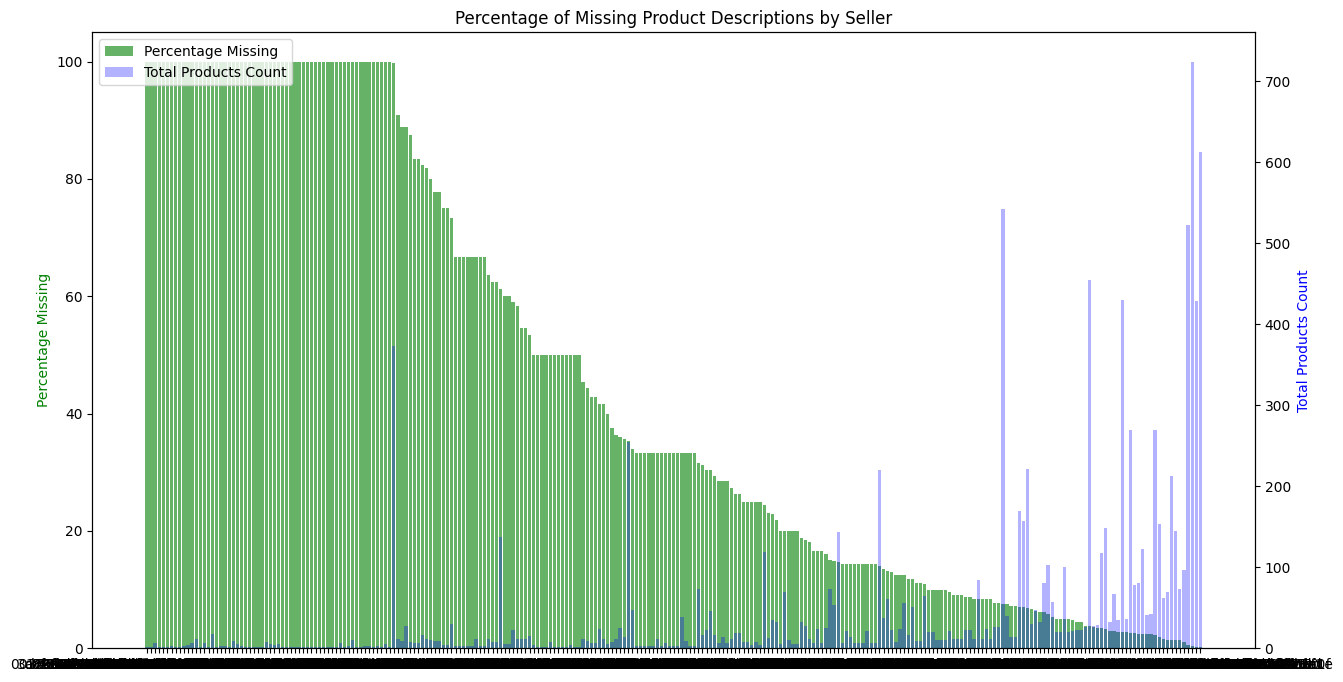

In [57]:
import matplotlib.pyplot as plt

# Sorting values for better visualization
aggregated_df = aggregated_df.sort_values(by="percentage_missing", ascending=False)

# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(15, 8))

# Twin the axes
ax2 = ax1.twinx()

# Plot data
ax1.bar(aggregated_df['seller_id'], aggregated_df['percentage_missing'], color='g', alpha=0.6, label='Percentage Missing')
ax2.bar(aggregated_df['seller_id'], aggregated_df['total_products_count'], color='b', alpha=0.3, label='Total Products Count')

# Set the y axis label
ax1.set_ylabel('Percentage Missing', color='g')
ax2.set_ylabel('Total Products Count', color='b')

# To display the labels in the legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# Display the plot
plt.title('Percentage of Missing Product Descriptions by Seller')
plt.xticks(rotation=90)
plt.show()


In [58]:
issue_tracker.update_issue(
    potential_cause = "",
    notes = (
        "Reason for 610 missing product description can't be surely answerd.\n"
        "They are related to 257 different sellers.\n"
        "Most sellers with 100% missing descriptions have only a few products."
    )
)

---

Issue.5.6 (Missing values)
Data: products>product_category_name

---

Reason for 610 missing product description can't be surely answerd.
They are related to 257 different sellers.
Most sellers with 100% missing descriptions have only a few products.

---



### 5.1.9 `zip_code_prefix`

In [59]:
df_summaries["key"].query('column.str.contains("zip_code_prefix")')

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype
2,customers,customer_zip_code_prefix,99441,14994,84447,0,key,foreign
5,geolocation,geolocation_zip_code_prefix,1000163,19015,981148,0,key,primary
47,sellers,seller_zip_code_prefix,3095,2246,849,0,key,foreign


`customer_zip_code_prefix` and `seller_zip_code_prefix` were already identified as foreign key for `geolocation_zip_code_prefix`

In [60]:
issue_tracker.add_issue(
    description = "duplicated key values",
    relevant_data = "geolocation>geolocation_zip_code_prefix",
    potential_cause = "Zip code is not complete ('prefix') and is used for multiple locations.",
    notes = (
        "Check if duplicated zip_codes refers to same locations."
    ))

---

Issue.6.1 (duplicated key values)
Data: geolocation>geolocation_zip_code_prefix

---

Potential cause: Zip code is not complete ('prefix') and is used for multiple locations.

---

Check if duplicated zip_codes refers to same locations.

---



In [61]:
counts = db["geolocation"]["geolocation_zip_code_prefix"].value_counts()
counts[counts > 1]

geolocation_zip_code_prefix
24220    1146
24230    1102
38400     965
35500     907
11680     879
         ... 
54368       2
41402       2
54365       2
37702       2
48740       2
Name: count, Length: 17972, dtype: int64

In [62]:
db["geolocation"][db["geolocation"]["geolocation_zip_code_prefix"]==counts.index[0]]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
470805,24220,-22.905817,-43.106989,niteroi,RJ
470811,24220,-22.902306,-43.112545,niteroi,RJ
470812,24220,-22.904567,-43.110491,niteroi,RJ
470820,24220,-22.902575,-43.109192,niteroi,RJ
470821,24220,-22.907500,-43.106170,niteroi,RJ
...,...,...,...,...,...
474265,24220,-22.904023,-43.111683,niteroi,RJ
474266,24220,-22.905393,-43.100512,niterói,RJ
474269,24220,-22.906420,-43.104933,niteroi,RJ
474270,24220,-22.909701,-43.108452,niteroi,RJ


In [63]:
issue_tracker.update_issue(
    notes = (
        "Some cities have diacritical marks and some don't.\n"
        "Remove them using unidecode."
    )
)

---

Issue.6.2 (duplicated key values)
Data: geolocation>geolocation_zip_code_prefix

---

Potential cause: Zip code is not complete ('prefix') and is used for multiple locations.

---

Some cities have diacritical marks and some don't.
Remove them using unidecode.

---



In [64]:
db["geolocation"]["geolocation_city"] = db["geolocation"]["geolocation_city"].apply(unidecode)

In [65]:
def has_duplicate_rows(group):
    distinct_rows = group.drop_duplicates(subset=group.columns[-2:])
    return len(distinct_rows) > 1

repeated_review_ids = counts[counts > 1]
filtered_reviews = db["geolocation"][db["geolocation"]["geolocation_zip_code_prefix"].isin(repeated_review_ids.index)]
duplicate_check_per_review = filtered_reviews.groupby("geolocation_zip_code_prefix").apply(has_duplicate_rows)
review_ids_with_duplicates = duplicate_check_per_review[duplicate_check_per_review].index.tolist()

print(f"Number of duplicated review_ids where any column except order_id has non duplicated values: {len(review_ids_with_duplicates)}")

Number of duplicated review_ids where any column except order_id has non duplicated values: 556


In [66]:
for i, rid in enumerate(review_ids_with_duplicates[:100]):
    #print(db["geolocation"].query("geolocation_zip_code_prefix == @rid")["geolocation_state"].value_counts())
    print(i, db["geolocation"].query("geolocation_zip_code_prefix == @rid")["geolocation_city"].value_counts().index.to_list())
    print(i, db["geolocation"].query("geolocation_zip_code_prefix == @rid")["geolocation_city"].value_counts().to_list())

0 ['sao paulo', 'sao bernardo do campo']
0 [310, 1]
1 ['sao paulo']
1 [13]
2 ['sao paulo', 'jundiai']
2 [51, 1]
3 ['sao paulo', 'taboao da serra']
3 [105, 1]
4 ['sao paulo']
4 [179]
5 ['sao paulo', 'saopaulo']
5 [32, 1]
6 ['sao paulo', 'sp']
6 [72, 1]
7 ['sao paulo', 'saPSo paulo']
7 [71, 1]
8 ['sao paulo', 'sp']
8 [77, 1]
9 ['sao paulo', 'sao jose dos campos']
9 [146, 1]
10 ['sao paulo', 'sp']
10 [59, 1]
11 ['osasco', 'sao paulo']
11 [107, 1]
12 ['embu das artes', 'embu']
12 [74, 10]
13 ['embu das artes', 'embu']
13 [52, 11]
14 ['embu das artes', 'embu']
14 [31, 9]
15 ['embu das artes', 'embu']
15 [19, 3]
16 ['embu das artes', 'embu']
16 [116, 22]
17 ['embu das artes', 'embu']
17 [91, 20]
18 ['embu das artes', 'embu']
18 [84, 15]
19 ['embu das artes', 'embu']
19 [85, 21]
20 ['embu das artes', 'embu']
20 [106, 30]
21 ['embu das artes', 'embu']
21 [94, 23]
22 ['embu das artes', 'embu']
22 [17, 5]
23 ['embu das artes', 'embu']
23 [86, 22]
24 ['embu das artes', 'embu']
24 [140, 26]
25 ['e

In [67]:
issue_tracker.update_issue(
    notes = (
        "There are still different spellings for the same city.\n"
        "But also wrong cities with few value_counts within the same zip_code.\n\n"
        "Compare simlar names with fuzzywuzzy.\n"
        "Overwrite wrong city names with few value_counts."
    )
)

---

Issue.6.3 (duplicated key values)
Data: geolocation>geolocation_zip_code_prefix

---

Potential cause: Zip code is not complete ('prefix') and is used for multiple locations.

---

There are still different spellings for the same city.
But also wrong cities with few value_counts within the same zip_code.

Compare simlar names with fuzzywuzzy.
Overwrite wrong city names with few value_counts.

---



### 5.1.10 Issue Overview

In [68]:
issue_tracker.show_latest_versions().query("status=='Open'").formatted

,version,status,description,resolution,potential_cause,relevant_data,notes,timestamp
issue_id,,,,,,,,
1,1,Open,unique key in multiple tables,None,None,customers>customer_idorders>customer_id,one-to-one relationship;each customer has done exactly one order?;structure intenional?,2023-09-04 05:34:46
2,4,Open,duplicated key values,None,,customers>customer_unique_id,252 unique ids have different location dataAssumption could not be verified.-> Drop column: customer_unique_id,2023-09-04 05:34:46
4,4,Open,duplicated key values,None,duplicated values,order_reviews>review_id,Duplicated review_ids are real duplicates.Different order_ids still need to be investigated.,2023-09-04 05:34:59
5,6,Open,Missing values,None,,products>product_category_name,Reason for 610 missing product description can't be surely answerd.They are related to 257 different sellers.Most sellers with 100% missing descriptions have only a few products.,2023-09-04 05:34:59
6,3,Open,duplicated key values,None,Zip code is not complete ('prefix') and is used for multiple locations.,geolocation>geolocation_zip_code_prefix,There are still different spellings for the same city.But also wrong cities with few value_counts within the same zip_code.Compare simlar names with fuzzywuzzy.Overwrite wrong city names with few value_counts.,2023-09-04 05:35:04


## 5.2 Inspect Text Columns

In [69]:
df_summaries["text"]

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,mode,mode_count
33,order_reviews,review_comment_title,99224,4527,94696,87656,text,free-text,Recomendo,423.0
34,order_reviews,review_comment_message,99224,36159,63064,58247,text,free-text,Muito bom,230.0


In [70]:
import nltk
from nltk.tokenize import word_tokenize

# If not done previously, download the necessary datasets
nltk.download('punkt')

dd = db['order_reviews']['review_comment_title'].dropna().apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vynde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


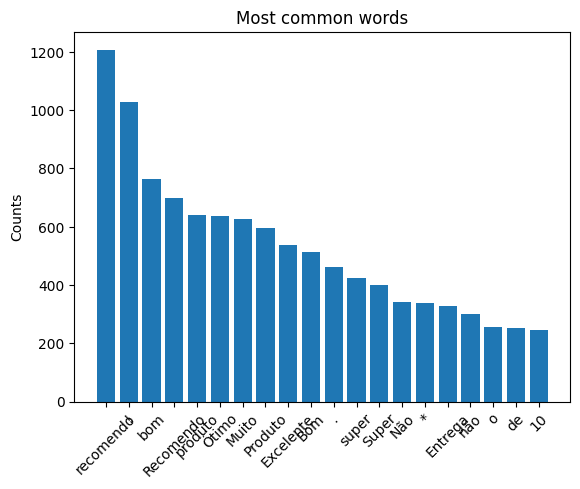

In [71]:
from collections import Counter
import matplotlib.pyplot as plt

# Get word frequencies
word_freq = Counter([word for tokens in dd for word in tokens])

# Most common words
common_words = word_freq.most_common(20)

# Plot
plt.bar([word[0] for word in common_words], [word[1] for word in common_words])
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.title('Most common words')
plt.show()


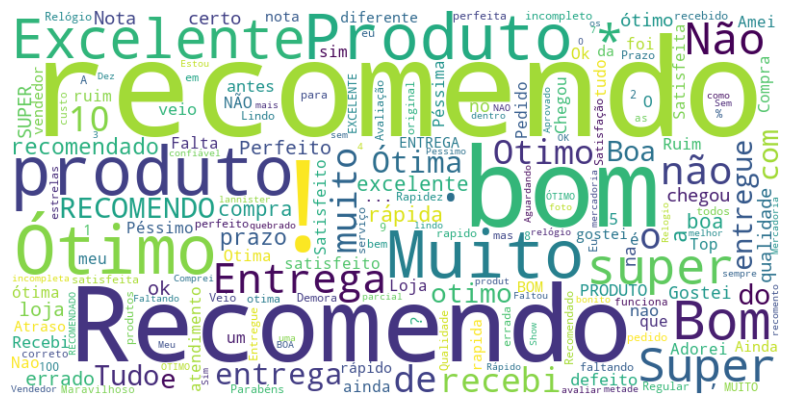

In [72]:
from wordcloud import WordCloud

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [73]:
dd

9                            [recomendo]
15                    [Super, recomendo]
19           [Não, chegou, meu, produto]
22                               [Ótimo]
34                       [Muito, bom, .]
                      ...               
99192                                [👍]
99196              [muito, bom, produto]
99197    [Não, foi, entregue, o, pedido]
99199                 [OTIMA, EMBALAGEM]
99200                   [Foto, enganosa]
Name: review_comment_title, Length: 11568, dtype: object

In [74]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# If not downloaded previously
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
ddd = db['order_reviews'][['review_comment_title']].copy().dropna()

ddd["sentiment"] = ddd["review_comment_title"].apply(sia.polarity_scores)
ddd

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vynde\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,review_comment_title,sentiment
9,recomendo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
15,Super recomendo,"{'neg': 0.0, 'neu': 0.204, 'pos': 0.796, 'comp..."
19,Não chegou meu produto,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
22,Ótimo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
34,Muito bom.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
...,...,...
99192,👍,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound..."
99196,muito bom produto,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
99197,Não foi entregue o pedido,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
99199,OTIMA EMBALAGEM,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [75]:
ddd[ddd["sentiment"]==1]

,review_comment_title,sentiment


## 5.3 Inspect Categorical Columns

Basic exploration for categorical variable will be frequency counts.

In [76]:
df_summaries["categorical"]

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,mode,mode_count
12,orders,order_status,99441,8,99433,0,categorical,nominal,delivered,96478.0
27,order_payments,payment_type,103886,5,103881,0,categorical,nominal,credit_card,76795.0


### 5.3.1 `order_status`

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

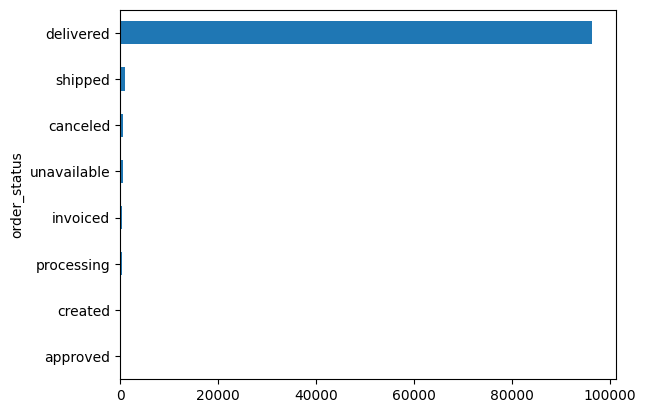

In [77]:
db["orders"]["order_status"].value_counts()[::-1].plot.barh()
db["orders"]["order_status"].value_counts()

### 5.3.2 `payment_type`

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

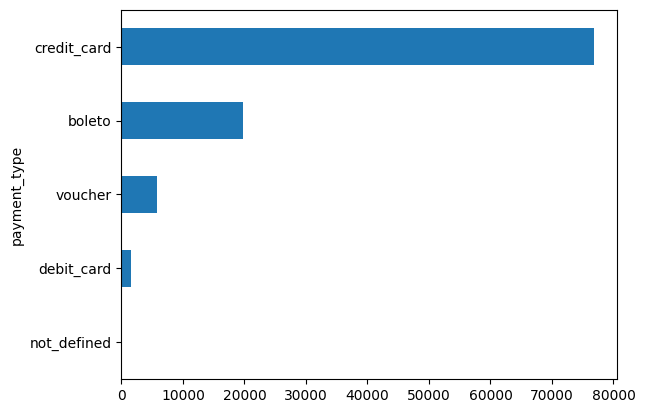

In [78]:
db["order_payments"]["payment_type"].value_counts()[::-1].plot.barh()
db["order_payments"]["payment_type"].value_counts()

No issues with categorical variables

## 5.4 Inspect Numeric Columns

When checking the data integrity of numeric variables, the following is considered:
- Presence of missing values.
- Occurrences of value '0' where it may be inappropriate.
- Exceptionally large values.
- Potential anomalies in value distributions.

In [79]:
df_summaries["numeric"]

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
23,order_items,price,112650,5968,106682,0,numeric,continuous,0.85,6735.00,120.653739
24,order_items,freight_value,112650,6999,105651,0,numeric,continuous,0.00,409.68,19.990320
26,order_payments,payment_sequential,103886,29,103857,0,numeric,discrete,1.00,29.00,1.092679
28,order_payments,payment_installments,103886,24,103862,0,numeric,discrete,0.00,24.00,2.853349
29,order_payments,payment_value,103886,29077,74809,0,numeric,continuous,0.00,13664.08,154.100380
32,order_reviews,review_score,99224,5,99219,0,numeric,discrete,1.00,5.00,4.086421
39,products,product_name_lenght,32951,66,32884,610,numeric,discrete,5.00,76.00,48.476949
40,products,product_description_lenght,32951,2960,29990,610,numeric,discrete,4.00,3992.00,771.495285
41,products,product_photos_qty,32951,19,32931,610,numeric,discrete,1.00,20.00,2.188986
42,products,product_weight_g,32951,2204,30746,2,numeric,discrete,0.00,40425.00,2276.472488


Missing values for `product_name_lenght`, `product_description_lenght`, and `product_photos_qty` where already discussed in [5.1.8](#518-product_category_name)  with the `product_category_name`

### 5.4.1 `price`

In [80]:
df_summaries["numeric"].query('column == "price"')

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
23,order_items,price,112650,5968,106682,0,numeric,continuous,0.85,6735.0,120.653739


In [81]:
issue_tracker.add_issue(
    description = "Large values",
    relevant_data = "order_items>price",
    notes = (
        "Check if values are reasonable."
    )
)

---

Issue.7.1 (Large values)
Data: order_items>price

---

Check if values are reasonable.

---



Histogram of prices above 2500

<Axes: >

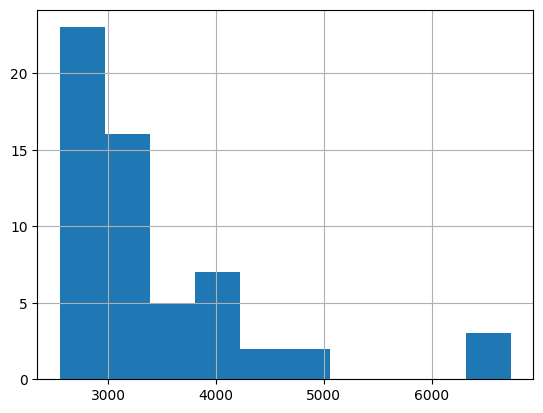

In [82]:
db["order_items"].query("price > 2500")["price"].hist()

Inspect product categories for the 15 most expensive products

In [83]:
df = db["order_items"].sort_values(by="price", ascending=False).head(15)\
    .merge(db["products"], on="product_id")\
    .merge(db["product_category_name_translation"], on="product_category_name")\

df[sorted(df.columns)].sort_values(by="product_category_name_english")

,freight_value,order_id,order_item_id,price,product_category_name,product_category_name_english,product_description_lenght,product_height_cm,product_id,product_length_cm,product_name_lenght,product_photos_qty,product_weight_g,product_width_cm,seller_id,shipping_limit_date
3,227.66,f5136e38d1a14a4dbd87dff67da82701,1,6499.00,artes,art,3954.0,25.0,1bdf5e6731585cf01aa8169c7028d6ad,47.0,28.0,2.0,7400.0,25.0,ee27a8f15b1dded4d213a468ba4eb391,2017-06-15 02:45:17
13,135.44,9de73f3e6157169ad6c32b9f313c7dcb,1,3899.00,bebes,baby,1064.0,57.0,0eb41884a8773e019708fb8409fd8347,76.0,41.0,1.0,21467.0,51.0,c510bc1718f0f2961eaa42a23330681a,2018-06-13 12:55:49
1,193.21,fefacc66af859508bf1a7934eab1e97f,1,6729.00,pcs,computers,1935.0,18.0,69c590f7ffc7bf8db97190b6cb6ed62e,54.0,50.0,4.0,5660.0,47.0,80ceebb4ee9b31afb6c6a916a574a1e2,2018-08-02 04:05:13
2,91.78,8dbc85d1447242f3b127dda390d56e19,1,4590.00,pcs,computers,1710.0,10.0,259037a6a41845e455183f89c5035f18,35.0,55.0,2.0,2900.0,40.0,c72de06d72748d1a0dfb2125be43ba63,2018-06-28 12:36:36
8,75.27,68101694e5c5dc7330c91e1bbc36214f,1,4099.99,consoles_games,consoles_games,3172.0,10.0,6cdf8fc1d741c76586d8b6b15e9eef30,34.0,59.0,1.0,3050.0,22.0,ed4acab38528488b65a9a9c603ff024a,2018-04-05 08:27:27
12,49.55,41b7766bb1df487d17fb9725b78ff509,1,3930.00,ferramentas_jardim,garden_tools,1903.0,38.0,0563d4cc419141eab2e5b438046e844e,17.0,41.0,1.0,5650.0,32.0,039e6ad9dae79614493083e241147386,2018-05-21 18:16:06
0,194.31,0812eb902a67711a1cb742b3cdaa65ae,1,6735.00,utilidades_domesticas,housewares,875.0,61.0,489ae2aa008f021502940f251d4cce7f,60.0,31.0,2.0,30000.0,33.0,e3b4998c7a498169dc7bce44e6bb6277,2017-02-16 20:37:36
7,113.45,426a9742b533fc6fed17d1fd6d143d7e,1,4399.87,instrumentos_musicais,musical_instruments,944.0,34.0,a1beef8f3992dbd4cd8726796aa69c53,71.0,59.0,3.0,3550.0,22.0,512d298ac2a96d1931b6bd30aa21f61d,2018-08-16 14:24:28
4,151.34,a96610ab360d42a2e5335a3998b4718a,1,4799.00,eletroportateis,small_appliances,1780.0,40.0,a6492cc69376c469ab6f61d8f44de961,55.0,41.0,2.0,22600.0,40.0,59417c56835dd8e2e72f91f809cd4092,2017-04-18 13:25:18
5,74.34,199af31afc78c699f0dbf71fb178d4d4,1,4690.00,eletroportateis,small_appliances,2217.0,49.0,c3ed642d592594bb648ff4a04cee2747,50.0,59.0,2.0,30000.0,50.0,59417c56835dd8e2e72f91f809cd4092,2017-05-09 15:50:15


In [84]:
issue_tracker.update_issue(
    notes = (
        "Although the prices may be very high they are still possible.\n"
        "Many products are also heavy.\n\n"
        "Keep values."
    )
)

---

Issue.7.2 (Large values)
Data: order_items>price

---

Although the prices may be very high they are still possible.
Many products are also heavy.

Keep values.

---



In [85]:
issue_tracker.resolve_issue("Values are considered reasonable.")

---

Issue.7.3 (Large values)
Data: order_items>price

---

Resolved: Values are considered reasonable.


### 5.4.2 `payment_value`

In [86]:
df_summaries["numeric"].query('column == "payment_value"')

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
29,order_payments,payment_value,103886,29077,74809,0,numeric,continuous,0.0,13664.08,154.10038


In [87]:
issue_tracker.add_issue(
    description = "Possible invalid value '0'",
    relevant_data = "order_payments>payment_value",
    potential_cause = "Products not delivered or transaction cancelled.",
    notes = (
        "Inspect 0 payments."
    )
)

---

Issue.8.1 (Possible invalid value '0')
Data: order_payments>payment_value

---

Potential cause: Products not delivered or transaction cancelled.

---

Inspect 0 payments.

---



In [88]:
zero_payments = db["order_payments"].query("payment_value==0")
zero_payments

,order_id,payment_sequential,payment_type,payment_installments,payment_value
19922,8bcbe01d44d147f901cd3192671144db,4,voucher,1,0.0
36822,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.0
43744,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.0
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
62674,45ed6e85398a87c253db47c2d9f48216,3,voucher,1,0.0
77885,fa65dad1b0e818e3ccc5cb0e39231352,13,voucher,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0
100766,b23878b3e8eb4d25a158f57d96331b18,4,voucher,1,0.0


Can't be explained by the payments data alone. `payment_sequential` infers, that there were multiple payment attempts.

In [89]:
issue_tracker.update_issue(
    notes = (
        "Payment type is voucher or not_defined.\n"
        "payment_sequential infers multiple payment attempts.\n\n"
        "Inspect complete orders."
    )
)

---

Issue.8.2 (Possible invalid value '0')
Data: order_payments>payment_value

---

Potential cause: Products not delivered or transaction cancelled.

---

Payment type is voucher or not_defined.
payment_sequential infers multiple payment attempts.

Inspect complete orders.

---



In [90]:
filtered_orders = db["orders"][db["orders"]["order_id"].isin(zero_payments["order_id"])]
db["order_payments"].merge(filtered_orders, on="order_id").sort_values(by=["order_id", "payment_sequential"])

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
45,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.00,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
34,45ed6e85398a87c253db47c2d9f48216,1,voucher,1,21.13,8eab8f9b3c744b76b65f7a2c0c8f2d6c,delivered,2017-06-08 21:18:45,2017-06-08 21:30:18,2017-06-09 08:35:18,2017-06-22 17:44:53,2017-07-10
33,45ed6e85398a87c253db47c2d9f48216,2,voucher,1,50.01,8eab8f9b3c744b76b65f7a2c0c8f2d6c,delivered,2017-06-08 21:18:45,2017-06-08 21:30:18,2017-06-09 08:35:18,2017-06-22 17:44:53,2017-07-10
35,45ed6e85398a87c253db47c2d9f48216,3,voucher,1,0.00,8eab8f9b3c744b76b65f7a2c0c8f2d6c,delivered,2017-06-08 21:18:45,2017-06-08 21:30:18,2017-06-09 08:35:18,2017-06-22 17:44:53,2017-07-10
44,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.00,a73c1f73f5772cf801434bf984b0b1a7,canceled,2018-09-03 14:14:25,NaT,NaT,NaT,2018-09-10
36,6ccb433e00daae1283ccc956189c82ae,1,credit_card,5,84.67,843b211abe7b0264dd4a69eafc5bdf43,delivered,2017-10-26 23:51:35,2017-10-27 00:46:58,2017-10-27 19:53:03,2017-11-08 18:47:00,2017-11-22
39,6ccb433e00daae1283ccc956189c82ae,2,voucher,1,14.65,843b211abe7b0264dd4a69eafc5bdf43,delivered,2017-10-26 23:51:35,2017-10-27 00:46:58,2017-10-27 19:53:03,2017-11-08 18:47:00,2017-11-22
38,6ccb433e00daae1283ccc956189c82ae,3,voucher,1,22.72,843b211abe7b0264dd4a69eafc5bdf43,delivered,2017-10-26 23:51:35,2017-10-27 00:46:58,2017-10-27 19:53:03,2017-11-08 18:47:00,2017-11-22
37,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.00,843b211abe7b0264dd4a69eafc5bdf43,delivered,2017-10-26 23:51:35,2017-10-27 00:46:58,2017-10-27 19:53:03,2017-11-08 18:47:00,2017-11-22
31,8bcbe01d44d147f901cd3192671144db,1,credit_card,1,36.21,f2def7f64f36952f2f5a9791f0285f34,delivered,2018-01-24 23:24:14,2018-01-24 23:37:20,2018-01-30 22:43:30,2018-02-02 21:26:42,2018-02-21


In [91]:
issue_tracker.update_issue(
    potential_cause = "Cancelled transaction. Party of larger multi sequential payment.",
    notes = (
        "Not_defined payment types are cancelled orders.\n"
        "Other zero payments refer to vouchers used in a multi sequential payment.\n"
        "The order itself was not free.\n"
    )
)

---

Issue.8.3 (Possible invalid value '0')
Data: order_payments>payment_value

---

Potential cause: Cancelled transaction. Party of larger multi sequential payment.

---

Not_defined payment types are cancelled orders.
Other zero payments refer to vouchers used in a multi sequential payment.
The order itself was not free.


---



In [92]:
issue_tracker.resolve_issue("Zero payment records are valid.")

---

Issue.8.4 (Possible invalid value '0')
Data: order_payments>payment_value

---

Potential cause: Cancelled transaction. Party of larger multi sequential payment.

---

Resolved: Zero payment records are valid.


### 5.4.3 `product_weight_g`

In [93]:
df_summaries["numeric"].query('column == "product_weight_g"')

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
42,products,product_weight_g,32951,2204,30746,2,numeric,discrete,0.0,40425.0,2276.472488


In [94]:
issue_tracker.add_issue(
    description = "Missing values.",
    relevant_data = "products>product_weight_g",
    notes = (
        "Inspect missing values."
    )
)

---

Issue.9.1 (Missing values.)
Data: products>product_weight_g

---

Inspect missing values.

---



In [95]:
db["products"][db["products"]["product_weight_g"].isna()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# Are there items sold for the product without any description?
len(db["order_items"].query("product_id=='5eb564652db742ff8f28759cd8d2652a'"))

17

In [97]:
issue_tracker.update_issue(
    notes = (
        "Seller probably forgot to provide the information.\n\n"
        "Ignore missing values."
    )
)

---

Issue.9.2 (Missing values.)
Data: products>product_weight_g

---

Seller probably forgot to provide the information.

Ignore missing values.

---



In [98]:
issue_tracker.add_issue(
    description = "Possible invalid value '0'",
    relevant_data = "products>product_weight_g",
    notes = (
        "Inspect 0 weights."
    )
)

---

Issue.10.1 (Possible invalid value '0')
Data: products>product_weight_g

---

Inspect 0 weights.

---



In [99]:
db["products"].merge(db["product_category_name_translation"], on="product_category_name").query("product_weight_g==0")

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
13462,81781c0fed9fe1ad6e8c81fca1e1cb08,cama_mesa_banho,51.0,529.0,1.0,0.0,30.0,25.0,30.0,bed_bath_table
13831,8038040ee2a71048d4bdbbdc985b69ab,cama_mesa_banho,48.0,528.0,1.0,0.0,30.0,25.0,30.0,bed_bath_table
13955,36ba42dd187055e1fbe943b2d11430ca,cama_mesa_banho,53.0,528.0,1.0,0.0,30.0,25.0,30.0,bed_bath_table
15507,e673e90efa65a5409ff4196c038bb5af,cama_mesa_banho,53.0,528.0,1.0,0.0,30.0,25.0,30.0,bed_bath_table


In [100]:
issue_tracker.update_issue(
    potential_cause = "Seller did not provide correct information.",
    notes = (
        "4 products out of 32951 have zero weights.\n"
        "The attributes infer that all products are variants of the same product.\n\n"
        "Ignore."
    )
)

---

Issue.10.2 (Possible invalid value '0')
Data: products>product_weight_g

---

Potential cause: Seller did not provide correct information.

---

4 products out of 32951 have zero weights.
The attributes infer that all products are variants of the same product.

Ignore.

---



### 5.4.4 Histograms

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
23,order_items,price,112650,5968,106682,0,numeric,continuous,0.85,6735.0,120.653739


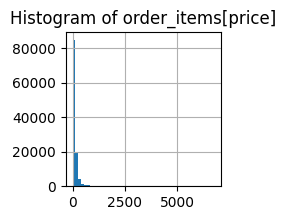

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
24,order_items,freight_value,112650,6999,105651,0,numeric,continuous,0.0,409.68,19.99032


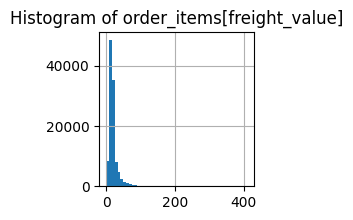

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
26,order_payments,payment_sequential,103886,29,103857,0,numeric,discrete,1.0,29.0,1.092679


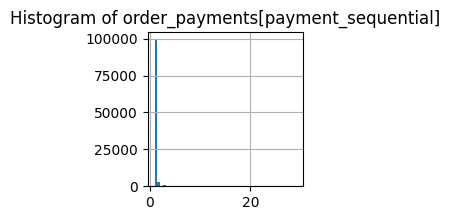

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
28,order_payments,payment_installments,103886,24,103862,0,numeric,discrete,0.0,24.0,2.853349


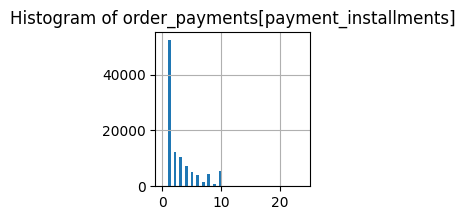

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
29,order_payments,payment_value,103886,29077,74809,0,numeric,continuous,0.0,13664.08,154.10038


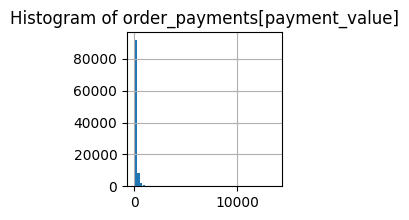

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
32,order_reviews,review_score,99224,5,99219,0,numeric,discrete,1.0,5.0,4.086421


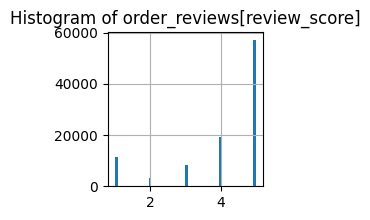

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
39,products,product_name_lenght,32951,66,32884,610,numeric,discrete,5.0,76.0,48.476949


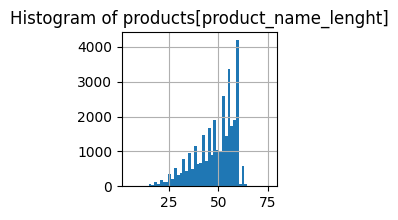

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
40,products,product_description_lenght,32951,2960,29990,610,numeric,discrete,4.0,3992.0,771.495285


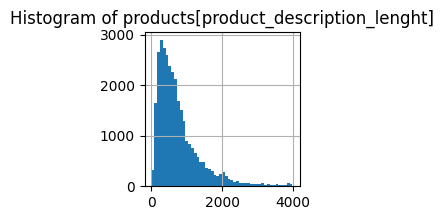

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
41,products,product_photos_qty,32951,19,32931,610,numeric,discrete,1.0,20.0,2.188986


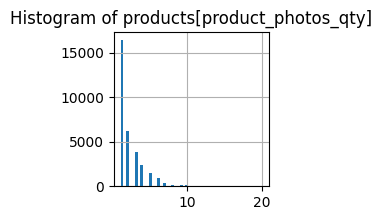

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
42,products,product_weight_g,32951,2204,30746,2,numeric,discrete,0.0,40425.0,2276.472488


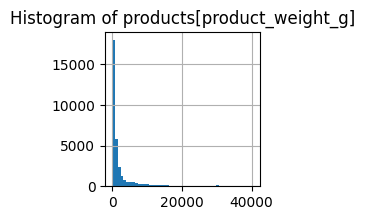

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
43,products,product_length_cm,32951,99,32851,2,numeric,discrete,7.0,105.0,30.815078


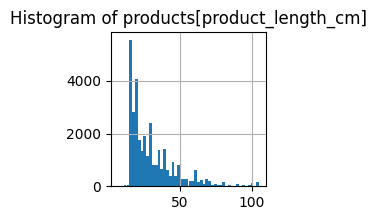

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
44,products,product_height_cm,32951,102,32848,2,numeric,discrete,2.0,105.0,16.937661


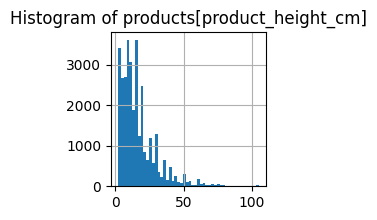

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min,max,mean
45,products,product_width_cm,32951,95,32855,2,numeric,discrete,6.0,118.0,23.196728


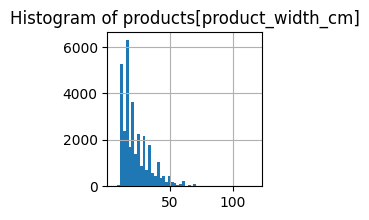

In [101]:
from IPython.display import display

for i, row in df_summaries["numeric"][["table", "column"]].iterrows():
    table, column = row["table"], row["column"]
    plt.figure(figsize=[2,2])
    display(df_summaries["numeric"].query(f'(table=="{table}") and (column=="{column}")'))
    db[table][column].hist(bins=50)
    plt.title(f'Histogram of {row["table"]}[{row["column"]}]')
    plt.show()

No suspicious histograms.

## 5.5 Inspect Temporal Columns

The temporal data spans approxamitely 2 years.

In [102]:
df_summaries["temporal"]

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype,min_date,max_date,range
13,orders,order_purchase_timestamp,99441,98875,566,0,temporal,datetime,2016-09-04 21:15:19,2018-10-17 17:30:18,772 days 20:14:59
14,orders,order_approved_at,99441,90733,8707,160,temporal,datetime,2016-09-15 12:16:38,2018-09-03 17:40:06,718 days 05:23:28
15,orders,order_delivered_carrier_date,99441,81018,18422,1783,temporal,datetime,2016-10-08 10:34:01,2018-09-11 19:48:28,703 days 09:14:27
16,orders,order_delivered_customer_date,99441,95664,3776,2965,temporal,datetime,2016-10-11 13:46:32,2018-10-17 13:22:46,735 days 23:36:14
17,orders,order_estimated_delivery_date,99441,459,98982,0,temporal,date,2016-09-30 00:00:00,2018-11-12 00:00:00,773 days 00:00:00
22,order_items,shipping_limit_date,112650,93318,19332,0,temporal,datetime,2016-09-19 00:15:34,2020-04-09 22:35:08,1298 days 22:19:34
35,order_reviews,review_creation_date,99224,636,98588,0,temporal,datetime,2016-10-02 00:00:00,2018-08-31 00:00:00,698 days 00:00:00
36,order_reviews,review_answer_timestamp,99224,98248,976,0,temporal,datetime,2016-10-07 18:32:28,2018-10-29 12:27:35,751 days 17:55:07


### 5.5.1 Missing data in `orders` table

In [103]:
db["orders"][(db["orders"]["order_approved_at"].isna())]["order_status"].value_counts()

order_status
canceled     141
delivered     14
created        5
Name: count, dtype: int64

In [104]:
issue_tracker.add_issue(
    description = "Missing values",
    relevant_data = "orders>order_approved_at",
    notes = (
        "Orders should be approved before it's delivered.\n"
        "14 records violate this rule."
    )
)

---

Issue.11.1 (Missing values)
Data: orders>order_approved_at

---

Orders should be approved before it's delivered.
14 records violate this rule.

---



In [105]:
db["orders"][(db["orders"]["order_delivered_carrier_date"].isna())]["order_status"].value_counts()

order_status
unavailable    609
canceled       550
invoiced       314
processing     301
created          5
approved         2
delivered        2
Name: count, dtype: int64

In [106]:
issue_tracker.add_issue(
    description = "Missing values",
    relevant_data = "orders>order_delivered_carrier_date",
    notes = (
        "Orders should be marked as delivered to carrier before it's delivered.\n"
        "2 records violate this rule."
    )
)

---

Issue.12.1 (Missing values)
Data: orders>order_delivered_carrier_date

---

Orders should be marked as delivered to carrier before it's delivered.
2 records violate this rule.

---



In [107]:
db["orders"][(db["orders"]["order_delivered_customer_date"].isna())]["order_status"].value_counts()

order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: count, dtype: int64

In [108]:
issue_tracker.add_issue(
    description = "Missing values",
    relevant_data = "orders>order_delivered_customer_date",
    notes = (
        "Orders should have delivered dates when delivered.\n"
        "8 records violate this rule."
    )
)

---

Issue.13.1 (Missing values)
Data: orders>order_delivered_customer_date

---

Orders should have delivered dates when delivered.
8 records violate this rule.

---



In [109]:
db["order_reviews"]["duration"] = db["order_reviews"]["review_answer_timestamp"] - db["order_reviews"]["review_creation_date"]
average_duration = db["order_reviews"]["duration"].mean()
print(f"On average, it takes {average_duration} to answer a review.")


On average, it takes 3 days 03:34:33.029700475 to answer a review.


### 5.5.2 Max `shipping_limit_data` is different from other columns

In [110]:
df = db["order_items"].merge(db["orders"], on="order_id").merge(db["customers"], on="customer_id").merge(db["sellers"], on="seller_id")
df["shipping_limit_duration"] = df["shipping_limit_date"] - df["order_purchase_timestamp"]
df.sort_values(by="shipping_limit_date", ascending=False).head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,shipping_limit_duration
78643,c2bb89b5c1dd978d507284be78a04cb2,1,87b92e06b320e803d334ac23966c80b1,7a241947449cc45dbfda4f9d0798d9d0,2020-04-09 22:35:08,99.99,61.44,6357fffb5704244d552615bbfcea1442,delivered,2017-05-23 22:28:36,...,2017-06-09 13:35:54,2017-10-11,44b6bbfea26596437062a38c8e6bcec1,15040,sao jose do rio preto,SP,37590,jacutinga,MG,1052 days 00:06:32
78644,c2bb89b5c1dd978d507284be78a04cb2,2,87b92e06b320e803d334ac23966c80b1,7a241947449cc45dbfda4f9d0798d9d0,2020-04-09 22:35:08,99.99,61.44,6357fffb5704244d552615bbfcea1442,delivered,2017-05-23 22:28:36,...,2017-06-09 13:35:54,2017-10-11,44b6bbfea26596437062a38c8e6bcec1,15040,sao jose do rio preto,SP,37590,jacutinga,MG,1052 days 00:06:32
78600,13bdf405f961a6deec817d817f5c6624,1,96ea060e41bdecc64e2de00b97068975,7a241947449cc45dbfda4f9d0798d9d0,2020-02-05 03:30:51,69.99,14.66,b279a1d441c73c1974d7a63618855aa0,canceled,2017-03-16 02:30:51,...,NaT,2017-08-08,3977f83a14549e6265bcded84e92ee80,21210,rio de janeiro,RJ,37590,jacutinga,MG,1056 days 01:00:00
78629,9c94a4ea2f7876660fa6f1b59b69c8e6,1,282b126b2354516c5f400154398f616d,7a241947449cc45dbfda4f9d0798d9d0,2020-02-03 20:23:22,75.99,14.70,22e922696a7d1ab9a19c6b702fedc387,shipped,2017-03-14 19:23:22,...,NaT,2017-08-04,b030929cf3b8c3370ea8c611f9ccb32e,71905,brasilia,DF,37590,jacutinga,MG,1056 days 01:00:00
51526,3b61aab5de69abc1731138bd104a777f,1,6aa063e063f2ab982b471e58afe06d72,610f72e407cdd7caaa2f8167b0163fd8,2018-09-18 21:10:15,999.99,24.77,8e29c6e9c795eda30cf7f47244720132,delivered,2018-08-25 20:59:18,...,2018-08-30 16:47:53,2018-09-21,101375bf617fd60c9eee42f98d9a73d6,5415,sao paulo,SP,1201,sao paulo,SP,24 days 00:10:57
86041,7cfdf7265c9572fc7b7cbd3b9cc438b7,2,17e18b0c88a853dd6de3e48a7cfa9d9a,cee48807215b30a12ca2ca10ffb5f250,2018-09-14 12:30:56,20.00,19.25,00791d8bb3acb245dc0b865656e18fff,delivered,2018-08-21 12:20:32,...,2018-08-27 19:18:43,2018-10-02,56b6eede1b10925212f054a7ba614796,37410,tres coracoes,MG,11431,guaruja,SP,24 days 00:10:24
51524,1afe384f199748cff7a42c9902065560,1,4c2a4020fcd651812100ebbeac1b2753,610f72e407cdd7caaa2f8167b0163fd8,2018-09-14 02:09:37,599.99,29.18,df646960391593c3f41cd448d84800c7,delivered,2018-08-21 01:45:43,...,2018-08-23 12:38:45,2018-09-19,24a438c52577c3c30ba86532b4166ff8,13035,campinas,SP,1201,sao paulo,SP,24 days 00:23:54
55213,59eaa904b3f0dbde2785ac1b27eccd18,1,61919b39651acb61ec24307ed8b9502d,f61c63d13f7cd800549d5acdd390ae72,2018-09-13 14:55:28,299.00,14.75,3e90b5882ce0e665b837de00a2a8625c,delivered,2018-08-20 10:19:46,...,2018-08-24 16:09:34,2018-09-18,7dc9f5b742ea9e6e4cff3ca5b1c8a78b,8675,suzano,SP,18185,pilar do sul,SP,24 days 04:35:42
100126,cf5c8d9f52807cb2d2f0a0ff54c478da,6,a7bbff32c7321478b29f924301a1867d,dfc475d54e1b6dbeeb7d7d9bdaa63827,2018-09-12 13:24:27,16.90,8.99,e898b5ef24833b9cb9e2d4f00b937595,delivered,2018-08-24 13:04:05,...,2018-08-30 19:11:50,2018-10-05,8dc697d03f771cecc2534534a73eaaf9,78050,cuiaba,MT,81460,curitiba,PR,19 days 00:20:22
72758,d4fae577806d683110e00e18a5e181be,4,7001d71d1ad858e07e5a341649412e76,f0b47fbbc6dee9aafe415a6e33051b3f,2018-09-12 03:15:36,49.99,3.57,49a6ae8a95c6a78d90945b983ab1ecfc,delivered,2018-08-28 19:32:05,...,2018-08-30 18:32:36,2018-09-12,fb7e29c65321441231990afc201c1b14,4107,sao paulo,SP,9360,maua,SP,14 days 07:43:31


In [111]:
df["shipping_limit_duration"].describe()

count                       112650
mean     6 days 15:27:03.728308921
std      7 days 01:39:33.041016437
min                2 days 00:06:06
25%                5 days 00:09:53
50%                6 days 00:17:16
75%                7 days 04:30:03
max             1056 days 01:00:00
Name: shipping_limit_duration, dtype: object

In [112]:
issue_tracker.add_issue(
    description = "Large values",
    relevant_data = "order_items>shipping_limit_duration",
    potential_cause = "Wrong values",
    notes = (
        "Large values are obviously wrong.\n"
        "The 4 latest dates are related to the same seller.\n\n"
        "Outliers should be set to nan"
    )
)

---

Issue.14.1 (Large values)
Data: order_items>shipping_limit_duration

---

Potential cause: Wrong values

---

Large values are obviously wrong.
The 4 latest dates are related to the same seller.

Outliers should be set to nan

---



### 5.5.3 Sequence Order of Timestamps

Correct order should be:
- order_purchase_timestamp
- order_approved_at
- order_delivered_carrier_date
- order_delivered_customer_date

Number of invalid occurrences of `order_purchase_timestamp` after `order_approved_at`

In [113]:
db["orders"].query("order_purchase_timestamp > order_approved_at").count()[0]

0

Number of invalid occurrences of `order_purchase_timestamp` after `order_delivered_carrier_date`

In [114]:
db["orders"].query("order_purchase_timestamp > order_delivered_carrier_date").count()[0]

166

In [115]:
issue_tracker.add_issue(
    description = "Invalid values",
    relevant_data = "orders>order_delivered_carrier_date",
    notes = (
        "166 occurrences of purchase timestamps later then delivered carrier timestamps\n"
        "If product is at carrier during purchase, timestamps should be the same.\n"
        "This is invalid."
    )
)

---

Issue.15.1 (Invalid values)
Data: orders>order_delivered_carrier_date

---

166 occurrences of purchase timestamps later then delivered carrier timestamps
If product is at carrier during purchase, timestamps should be the same.
This is invalid.

---



In [116]:
db["orders"].query("order_purchase_timestamp > order_delivered_carrier_date").head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
615,b9afddbdcfadc9a87b41a83271c3e888,85c6af75161b8b2b1af98e82b5a6a5a5,delivered,2018-08-16 13:50:48,2018-08-16 14:05:13,2018-08-16 13:27:00,2018-08-24 14:58:37,2018-09-04
1111,ad133696906f6a78826daa0911b7daec,e6f5b234bb0d847f10eebd70130c5d49,delivered,2018-06-15 15:41:22,2018-06-15 16:19:23,2018-06-15 14:52:00,2018-06-22 18:09:37,2018-07-18
1329,74e033208dc13a7b8127eb8e73d09b76,72fcbb1145f2889eddcba6d6c1d6c090,delivered,2018-05-02 10:48:44,2018-05-02 11:13:45,2018-05-02 09:49:00,2018-05-07 23:06:36,2018-05-29
1372,a6b58794fd2ba533359a76c08df576e3,ccd8e3459ad58ae538c9d2cf35532ba4,delivered,2018-05-14 15:18:23,2018-05-14 15:33:35,2018-05-14 13:46:00,2018-05-19 19:33:32,2018-06-08
1864,5792e0b1c8c8a2bf53af468c9a422c88,5c427f06e7fcf902e309743516e2c580,delivered,2018-07-26 13:25:14,2018-07-26 13:35:14,2018-07-26 12:42:00,2018-07-30 14:45:02,2018-08-09


In [117]:
print("All timestamps at whole minutes?")
db["orders"].query("order_purchase_timestamp > order_delivered_carrier_date")["order_delivered_carrier_date"].dt.second.eq(0).all()

All timestamps at whole minutes?


True

In [118]:
print("Fraction of potential manual inputs")
db["orders"]["order_delivered_carrier_date"].dt.second.eq(0).sum() / len(db["orders"])

Fraction of potential manual inputs


0.29006144346899165

Values are not random 0.29 >> 0.166 (1/60)

In [119]:
issue_tracker.update_issue(
    potential_cause = "Manual input by sellers",
    notes = (
        "All 166 order_delivered_carrier_date timestamps are at whole minutes.\n"
        "This infers manual edits which lead to this issue.\n"
        "Around 30% of the delivered carrier timestamps are manual inputs."
    )
)

---

Issue.15.2 (Invalid values)
Data: orders>order_delivered_carrier_date

---

Potential cause: Manual input by sellers

---

All 166 order_delivered_carrier_date timestamps are at whole minutes.
This infers manual edits which lead to this issue.
Around 30% of the delivered carrier timestamps are manual inputs.

---



Number of invalid occurrences of `order_purchase_timestamp` after `order_delivered_customer_date`

In [120]:
db["orders"].query("order_purchase_timestamp > order_delivered_customer_date").count()[0]

0

Number of invalid occurrences of `order_approved_at` after `order_delivered_carrier_date`

In [121]:
db["orders"].query("order_approved_at > order_delivered_carrier_date").count()[0]

1359

In [122]:
print("Number of manual order_delivered_carrier_date inputs:")
db["orders"].query("order_approved_at > order_delivered_carrier_date")["order_delivered_carrier_date"].dt.second.eq(0).sum()

Number of manual order_delivered_carrier_date inputs:


864

In [123]:
issue_tracker.add_issue(
    description = "Invalid values",
    relevant_data = "orders>order_approved_at",
    notes = (
        "1359 observations where order was approved after delivered to carrier."
        "864 are related to manual input."
        "Others can't be explained and thus might be valid."
    )
)

---

Issue.16.1 (Invalid values)
Data: orders>order_approved_at

---

1359 observations where order was approved after delivered to carrier.864 are related to manual input.Others can't be explained and thus might be valid.

---



Number of invalid occurrences of `order_approved_at` after `order_delivered_customer_date`

In [124]:
db["orders"].query("order_approved_at > order_delivered_customer_date").count()[0]

61

In [125]:
db["orders"].query("order_approved_at > order_delivered_customer_date").head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
199,58d4c4747ee059eeeb865b349b41f53a,1755fad7863475346bc6c3773fe055d3,delivered,2018-07-21 12:49:32,2018-07-26 23:31:53,2018-07-24 12:57:00,2018-07-25 23:58:19,2018-07-31
483,4df92d82d79c3b52c7138679fa9b07fc,ba0660bf3fffe505ee892e153a2fbd49,delivered,2018-07-24 11:32:11,2018-07-29 23:30:52,2018-07-26 14:46:00,2018-07-27 18:55:57,2018-08-06
1986,6e57e23ecac1ae881286657694444267,2dda54e25d0984e12705c84d4030e6e0,delivered,2018-08-09 17:36:47,2018-08-20 15:55:42,2018-08-14 13:26:00,2018-08-17 16:45:45,2018-09-06
3659,f222c56f035b47dfa1e069a88235d730,b74ca180d63f9ae0443e4e13a2f5bdaf,delivered,2018-01-30 09:43:45,2018-02-04 23:31:47,2018-01-31 19:48:44,2018-02-01 20:10:38,2018-02-15
11738,cf72398d0690f841271b695bbfda82d2,2b7fff075bda701552485ef3f0810257,delivered,2017-09-01 18:45:33,2017-09-13 22:04:39,2017-09-04 20:12:41,2017-09-11 14:15:02,2017-09-21


In [126]:
issue_tracker.update_issue(
    notes = (
        "61 observations where product was delivered after order was approved.\n"
        "May also be valid data due to delayed approval by the seller.\n"
        "Note that some observations are also related to manual inputs for delivered_carrier_dates"
    )
)

---

Issue.16.2 (Invalid values)
Data: orders>order_approved_at

---

61 observations where product was delivered after order was approved.
May also be valid data due to delayed approval by the seller.
Note that some observations are also related to manual inputs for delivered_carrier_dates

---



Number of invalid occurrences of `order_delivered_carrier_date` after `order_delivered_customer_date`

In [127]:
db["orders"].query("order_delivered_carrier_date > order_delivered_customer_date").count()[0]

23

In [128]:
db["orders"].query("order_delivered_carrier_date > order_delivered_customer_date").head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6437,a1abeb653a4d4cd1e142ccb8c82cd069,5f50465da00b7fed5dd1239f4ecf6e2c,delivered,2017-07-20 11:20:52,2017-07-21 06:43:14,2017-07-28 16:57:58,2017-07-25 19:32:56,2017-08-14
9553,383aa8b2724fe452d9ccd9934a8c628b,b1cb2f9d7a19480f3749e248db14d58f,delivered,2017-07-02 20:58:43,2017-07-02 21:10:20,2017-07-07 17:22:41,2017-07-06 14:27:51,2017-07-21
13487,cb1134f9010d242e9515ad1c78ec0c39,2fd33ac77677bd214b1882868317eeed,delivered,2017-07-16 12:35:34,2017-07-18 06:03:50,2017-07-20 19:22:02,2017-07-19 14:13:28,2017-08-08
14474,dceb62e8fa94b46006c9554fed743df0,2721900eb4e0f1cc2c836dd7bc1b1e11,delivered,2017-07-20 20:58:05,2017-07-22 11:45:11,2017-08-01 18:23:30,2017-07-26 18:09:10,2017-08-11
19268,5f9d46795c3126674e52becb3a1a517f,79287bcaafdde5c793b996fc40bb7d9f,delivered,2017-07-18 11:48:20,2017-07-18 12:03:29,2017-07-20 23:03:42,2017-07-20 18:52:41,2017-07-31


In [129]:
issue_tracker.add_issue(
    description = "Invalid values",
    relevant_data = "orders>order_delivered_customer_date",
    notes = (
        "23 occurrences where delivered carrier date is after delivered customer date.\n"
        "Must be either invalid or product is being returned."
    )
)

---

Issue.17.1 (Invalid values)
Data: orders>order_delivered_customer_date

---

23 occurrences where delivered carrier date is after delivered customer date.
Must be either invalid or product is being returned.

---



## 5.6 Inspect Spatial Columns

In [130]:
df_summaries["spatial"]

,table,column,count,unique_count,duplicated_count,missing_values,type,subtype
3,customers,customer_city,99441,4119,95322,0,spatial,region
4,customers,customer_state,99441,27,99414,0,spatial,region
6,geolocation,geolocation_lat,1000163,717360,282803,0,spatial,coordinates
7,geolocation,geolocation_lng,1000163,717613,282550,0,spatial,coordinates
8,geolocation,geolocation_city,1000163,8011,992152,0,spatial,coordinates
9,geolocation,geolocation_state,1000163,27,1000136,0,spatial,coordinates
48,sellers,seller_city,3095,611,2484,0,spatial,region
49,sellers,seller_state,3095,23,3072,0,spatial,region
